# Maxwell's Equations and Electromagnetic Radiation

Electromagnetic radiation surrounds us everday, from radio waves to light bulbs. These forms are often depicted with simplie sine or cosine waveforms. However, the current flowing through wires is often not as simple. As such, it is often useful to have a visual aid to assist in one's intuition for electromagnetic waves.

# Packages Needed

In [1]:
import numpy as np
import pylab as py
from scipy.integrate import simps
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, fftshift
import plotly.express as px
import plotly.graph_objects as go

# Constants

In [2]:
eps0 = 8.85e-12                     #permitivity of free space in vacuum
mu0 = 1.26e-6                       #magnetic constant (4pix10^-7)
c = 1/np.sqrt(eps0*mu0)             #speed of light
Z = np.sqrt(mu0/eps0)               #vaccuum impedance
jmax = 500
jsource = 250
nmax = 2500
Ex = np.zeros([jmax+1,2])  
Hz = np.zeros([jmax+1,2])  
lambda_min = 350e-9
dx = lambda_min/20
dt = dx/c
tau = 300
t0 = tau*3
lambda0 = 550e-9
omega = 2*np.pi*c/lambda0
freq = c/lambda0

t=np.linspace(0.,25.,100)
v = np.zeros(len(t))

# Definitions of all functions:

*   Input electric waves of different shapes (generated by Fourier Series)
*   The fourier transform function
*   The source function and it's options for the curl equations solution

Every function can be represented by an infinite sum of sine and cosine waves. 

The composition of waves of a function is called the Fourier series representation of the function. Alternatively, the Fourier transform gives the frequencies that make the Fourier series representation of that function, ie:

$$
f(x) = \frac{1}{2} a_0 + \sum_{n=1}^{\infty} a_n \cos(nx) + \sum_{n=1}^{\infty} b_n \sin(nx)
$$
Where
$$
\begin{aligned}
a_0 = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x) dx \\
a_n = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \cos(nx) dx \\
b_n = \frac{1}{\pi} \int_{-\pi}^{\pi} f(x) \sin(nx) dx \\
n = 1,2,3...
\end{aligned}
$$
The Fourier Transform can be written as follows

$$
	A(f) = \int_{-\infty}^\infty a(t) e^{-2\pi i f t} dt
$$

where a(t) is the function to transform, f is the frequency, and t is theinput variable. The Fast Fourier Transform employs a symmetry argument to reduce the computational time for the transform. Hence, the Fast Fourier Transform was employed for this project.

The Fourier Series for various different shapes of waves can be found at this [link.](https://mathworld.wolfram.com/topics/FourierSeries.html)

In [3]:
#Robbie
c=3.e8

#input in the form (kx-wt) like the solution to the wave equation
def inp(freq,t,x):
  omega = 2*np.pi*freq
  k=omega/(c)
  return(k*x-omega*t)


#sin waveform
#general form
def gensin(amp,freq,t,num):
  return(amp*np.sin(2*np.pi*freq*t/c))

#in form of solution to the wave equation
def sin(amp,freq,t,x,num):
  return(gensin(amp,freq,inp(freq,t,x),num))


#random waveform
#general form
def genrand(amp,t,num):
  func = 0 #function is empty
  for i in range(num):
    ramp = np.random.rand()*np.random.rand()*5 #random amplitude
    romega = np.random.rand()*2*np.pi*10000 #random frequency
    func += ramp*np.sin(romega/c*t) #function is the composition of sines
  return(func)

#in form of solution to the wave equation
def rand(amp,freq,t,x,num):
  return(genrand(amp,inp(freq,t,x),num))


#square waveform
#general form
def gensquare(amp,freq,t,num):
  func = 0 #function is blank initially
  nmax = 2*num-1 #square wave Fourier Series only uses odd numbers
  index = np.arange(1,nmax,2) #index of odd numbers
  L = c/(2*freq) #half of the wavelength
  for n in index:
    func += (1/n)*np.sin(n*np.pi*t/L)
  return(amp*(4/np.pi)*func)

#in form of solution to the wave equation
def square(amp,freq,t,x,num):
  return(gensquare(amp,freq,inp(freq,t,x),num))


#triangle waveform
#general form
def gentriangle(amp,freq,t,num):
  func = 0 #function is blank initially
  nmax = 2*num-1 #triangle wave Fourier Series only uses odd numbers
  index = np.arange(1,nmax,2) #index of odd numbers
  L = c/(2*freq) #half of the wavelength
  for n in index:
    func += (((-1)**((n-1)/2))/n**2)*np.sin(n*np.pi*t/L)
  return(amp*(8/(np.pi)**2)*func)

#in form of solution to the wave equation
def triangle(amp,freq,t,x,num):
  return(gentriangle(amp,freq,inp(freq,t,x),num))


#sawtooth waveform
#general form
def gensawtooth(amp,freq,t,num):
  func = 0 #function is initially blank
  nmax = num #sawtooth waveform uses all integers
  index = np.arange(1,nmax,1) #index of integers
  L = c/(2*freq) #half of the wavelength
  for n in index:
    func += (1/n)*np.sin(n*np.pi*t/L)
  return(2*amp*(-1/(np.pi))*func)

#in form of solution to the wave equation
def sawtooth(amp,freq,t,x,num):
  return(gensawtooth(amp,freq,inp(freq,t,x),num))

#==============================================#
#Robbie
#Fourier Transform Function (Fast Fourier Transform)
def ff(y,t):
  abundance = fft(y)/len(t)                      #fast fourier transform
  freq = fftfreq(n=y.size,d=2/len(t))/t[-1]      #frequency axis rescaled
  return(freq,abundance)

#==============================================#
#Blake
#Input for the source in solutions of Maxwell's Equations
#Pick and un-comment the input of choice

def source(t):
  #return sin(t)
  #return triangle(1e11,omega,t,0,500)
  #return square(1e9,omega,t,0,500)
  #return sawtooth(1e9,omega,t,0,500)
  #return rand(1,omega,t,0,500)
  return np.exp(-(t-t0)**2/tau**2)*np.sin(omega*t*dt)


Maxwell's curl equations are two different laws from the system of equations that model the functions of electromagnetism. They consist of the differential forms of Faraday's and Ampere's Laws, and are shown below.
$$
\begin{aligned}
  \nabla \times \vec{E} = -\frac{ \partial \vec{B} }{ \partial t} \\
  \nabla \times \vec{B} = \mu_0j + \frac{1}{c^2} \frac{\partial\vec{E}}{\partial t}
\end{aligned}
$$
These equations above are the ones commonly taught in physics classes, and are the differential forms of what we have seen in PY 202. But, for this problem working with H, or magnetic field density makes the equations simplify a little bit, and makes them easier to discretize. These rewritten equations look like:
$$
\begin{aligned}
  \nabla \times \vec{E} = -\mu_0\frac{ \partial \vec{H} }{ \partial t} \\
  \nabla \times \vec{H} = J + \epsilon_0\frac{\partial\vec{E}}{\partial t}
\end{aligned}
$$
In this situation, we are working with the functions of the magnetic and electric fields in one dimension, particularly where E is only in the x direction and H is only in the z direction, making the poynting vector of propogation in the y direction. Using these equations, we can discretize them, and make them easier to implement in the code. Here is the discretization below.
$$
\begin{aligned}
  H_z(j,n) = H_z(j,n-1) + \frac{\Delta t}{\mu_0 \Delta y}(E_x(j+1,n) - E_x(j,n) \\
  E_x(j,n+1) = E_x(j,n) + \frac{\Delta t}{\epsilon \Delta y} (H_z(j,n) - H_z(j-1,n)
\end{aligned}
$$
Resulting from this discretization, this is the general code for computation of solutions to Maxwell's Curl Equations.


In [4]:
#Blake
for n in range(nmax):
  #Magnetic field boundaries
  Hz[jmax-1,1] = Hz[jmax-2,0]
  #Update Magnetic field
  for j in range(jmax-1):
    Hz[j,1] = Hz[j,0] + dt/(dx*mu0) * (Ex[j+1,1] - Ex[j,1])
    Hz[j,0] = Hz[j,1]
  #Magnetic field source
  Hz[jsource-1,1] -= source(n)/Z

  #Update Electric Field boundaries
  Ex[0,1] = Ex[1,0]
  #Update electric field
  for j in range(1,jmax):
    Ex[j,1] = Ex[j,0] + dt/(dx*eps0) * (Hz[j,1]-Hz[j-1,1])
    Ex[j,0] = Ex[j,1]

  #Electric field source
  Ex[jsource,1] += source(n+1)
  Ex[jsource,0] = Ex[jsource,1]
  
  #Compute Fourier Transform
  t = np.linspace(-10.,10.,501)
  f = np.linspace(-2.,2.,40001)
  fE,freqE = ff(Ex[:,0],t)
  fH,freqH = ff(Hz[:,0],t)


# Plots
Below, one plot is of the general behavior of a Electromagnetic wave, that is a electric field and magnetic field that are orthogonal and proportional in magnitude, while the other is the first of the electric field waves defined and then used as inputs for code based upon Faraday's Law. 

C:\Users\blueb\AppData\Local\Temp\ipykernel_16328\1093803347.py:84: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



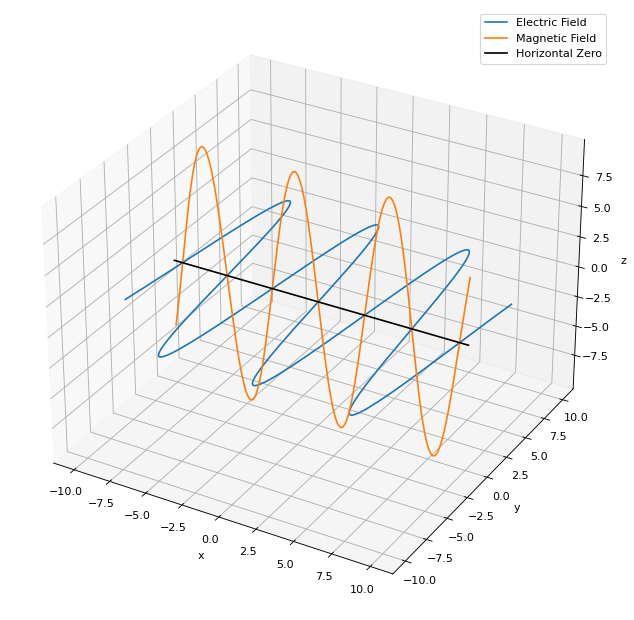

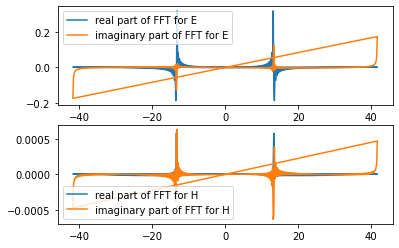

In [5]:
#Reed
def source(t):
    return np.exp(-(t-t0)**2/tau**2)*np.sin(omega*t*dt)

def gensin(amp,t,num):
    return(amp*np.sin(t))

def sin(amp,freq,t,x,num):
    return(gensin(amp,t,num))

def source_sin(t):
    return sin(1,omega,t,0,100)

v=np.zeros(len(t))

plt.figure(figsize=(10, 10), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(t, -sin(10,0.2,t,1,20), v,label= 'Electric Field ')
ax.plot3D(t, v, -sin(10,0.2,t,1,20),label= 'Magnetic Field ')
ax.plot(t,v,v, 'black',label= 'Horizontal Zero',)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()


Ex = np.zeros([jmax+1,2])  
Hz = np.zeros([jmax+1,2])  

for n in range(nmax):
  #Magnetic field boundaries
    Hz[jmax-1,1] = Hz[jmax-2,0]
  #Update Magnetic field
    for j in range(jmax-1):
        Hz[j,1] = Hz[j,0] + dt/(dx*mu0) * (Ex[j+1,1] - Ex[j,1])
        Hz[j,0] = Hz[j,1]
  #Magnetic field source
    Hz[jsource-1,1] -= source_sin(n)/Z

  #Update Electric Field boundaries
    Ex[0,1] = Ex[1,0]
  #Update electric field
    for j in range(1,jmax):
        Ex[j,1] = Ex[j,0] + dt/(dx*eps0) * (Hz[j,1]-Hz[j-1,1])
        Ex[j,0] = Ex[j,1]

  #Electric field source
    Ex[jsource,1] += source_sin(n+1)
    Ex[jsource,0] = Ex[jsource,1]
    
  #Compute Fourier Transform
    tax = np.linspace(-3.,3.,501)
    f = np.linspace(-2.,2.,40001)
    fE,freqE = ff(Ex[:,0],tax)
    fH,freqH = ff(Hz[:,0],tax)

fig = go.Figure()
fig.add_trace(
   go.Scatter3d(x=t, 
                y=Ex[:,1], 
                z=v,
                name = 'Electric Field',
                mode = 'lines'))
fig.add_trace(
   go.Scatter3d(x=t, 
                y=v, 
                z=Hz[:,1],
                name = 'Magnetic Field',
                mode = 'lines'))

fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

fig, axs = py.subplots(2,1)
axs[0].plot(fE, np.real(freqE),label='real part of FFT for E')
axs[0].plot(fE, np.imag(freqE),label='imaginary part of FFT for E')
axs[0].legend()
axs[1].plot(fH, np.real(freqH),label='real part of FFT for H')
axs[1].plot(fH, np.imag(freqH),label='imaginary part of FFT for H')
axs[1].legend()
fig.show()

Here, the below plots are of a random electric field and its expected, perpendicular magenetic field. The other plot is of that same electric field used as an input for the code based upon Faraday's Law. 

While the two plots are of the same input, the function emulates randomness and thus the two plots are not entirely comparable except for the nonuniform/constant shape. 

C:\Users\blueb\AppData\Local\Temp\ipykernel_16328\1443254400.py:86: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



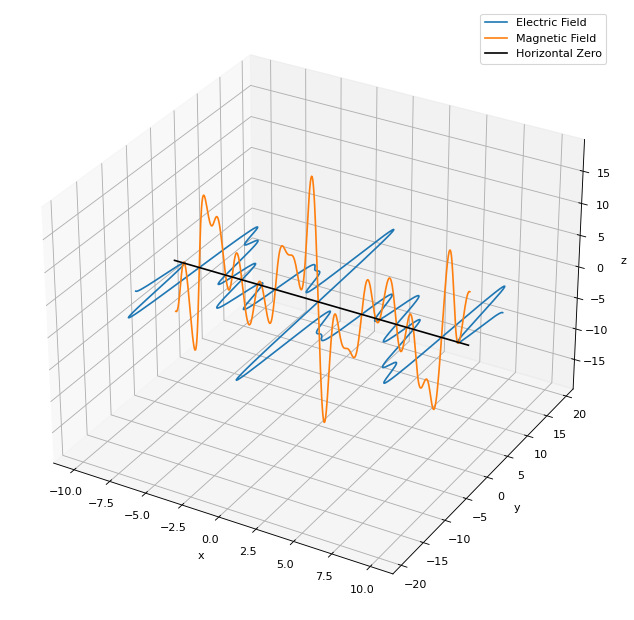

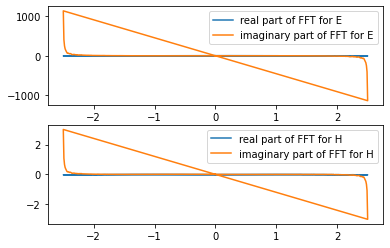

In [10]:
#Reed
def genrand(amp,t,num):
    func = 0
    for i in range(num):
        ramp = np.random.rand()*np.random.rand()*5
        romega = np.random.rand()*2*np.pi
        func += ramp*np.sin(romega*t)
    return(func)

def rand(amp,freq,t,x,num):
    return(genrand(amp,t,num))


def source_rand(t):
    return rand(1,omega,t,0,100)

plt.figure(figsize=(10, 10), dpi=80)
a = -rand(10,0.3,t,1,20)
ax = plt.axes(projection='3d')
ax.plot3D(t, a, v,label= 'Electric Field ')
ax.plot3D(t, v, a,label= 'Magnetic Field ')
ax.plot(t,v,v, 'black',label= 'Horizontal Zero',)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()


Ex = np.zeros([jmax+1,2])  
Hz = np.zeros([jmax+1,2])  

for n in range(nmax):
  #Magnetic field boundaries
    Hz[jmax-1,1] = Hz[jmax-2,0]
  #Update Magnetic field
    for j in range(jmax-1):
        Hz[j,1] = Hz[j,0] + dt/(dx*mu0) * (Ex[j+1,1] - Ex[j,1])
        Hz[j,0] = Hz[j,1]
  #Magnetic field source
    Hz[jsource-1,1] -= source_rand(n)/Z

  #Update Electric Field boundaries
    Ex[0,1] = Ex[1,0]
  #Update electric field
    for j in range(1,jmax):
        Ex[j,1] = Ex[j,0] + dt/(dx*eps0) * (Hz[j,1]-Hz[j-1,1])
        Ex[j,0] = Ex[j,1]

  #Electric field source
    Ex[jsource,1] += source_rand(n+1)
    Ex[jsource,0] = Ex[jsource,1]
    
  #Compute Fourier Transform
    tax = np.linspace(-50.,50.,501)
    f = np.linspace(-10.,10.,40001)
    fE,freqE = ff(Ex[:,0],tax)
    fH,freqH = ff(Hz[:,0],tax)

fig = go.Figure()
fig.add_trace(
   go.Scatter3d(x=t, 
                y=Ex[:,1], 
                z=v,
                name = 'Electric Field',
                mode = 'lines'))
fig.add_trace(
   go.Scatter3d(x=t, 
                y=v, 
                z=Hz[:,1],
                name = 'Magnetic Field',
                mode = 'lines'))

fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

fig, axs = py.subplots(2,1)
axs[0].plot(fE, np.real(freqE),label='real part of FFT for E')
axs[0].plot(fE, np.imag(freqE),label='imaginary part of FFT for E')
axs[0].legend()
axs[1].plot(fH, np.real(freqH),label='real part of FFT for H')
axs[1].plot(fH, np.imag(freqH),label='imaginary part of FFT for H')
axs[1].legend()
fig.show()

Like the previous plots, the below plots are of the defined wave for an electric field that is then used in code for Faraday's Law.

Here, the electric field is represented by a square wave. 

C:\Users\blueb\AppData\Local\Temp\ipykernel_16328\4025485495.py:85: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



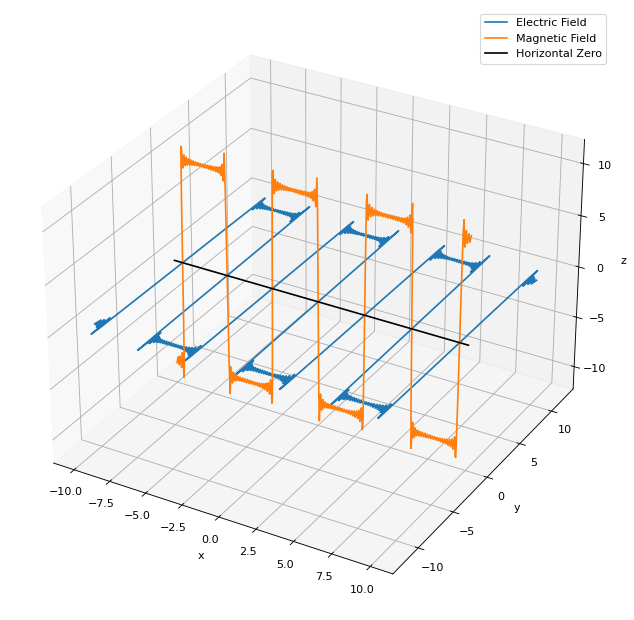

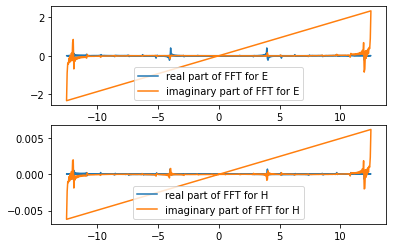

In [11]:
#Reed
def gensquare(amp,t,num):
    func = 0
    nmax = 2*num-1
    index = np.arange(1,nmax,2)
    L = np.pi
    for n in index:
        func += (1/n)*np.sin(n*np.pi*t/L)
    return(amp*(4/np.pi)*func)

def square(amp,freq,t,x,num):
    return(gensquare(amp,t,num))

def source_sq(t):
    return square(1,omega,t,0,100)
  
plt.figure(figsize=(10, 10), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(t, -square(10,0.2,t,1,20), v,label= 'Electric Field ')
ax.plot3D(t, v, -square(10,0.2,t,1,20),label= 'Magnetic Field ')
ax.plot(t,v,v, 'black',label= 'Horizontal Zero',)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()


Ex = np.zeros([jmax+1,2])  
Hz = np.zeros([jmax+1,2])  

for n in range(nmax):
  #Magnetic field boundaries
    Hz[jmax-1,1] = Hz[jmax-2,0]
  #Update Magnetic field
    for j in range(jmax-1):
        Hz[j,1] = Hz[j,0] + dt/(dx*mu0) * (Ex[j+1,1] - Ex[j,1])
        Hz[j,0] = Hz[j,1]
  #Magnetic field source
    Hz[jsource-1,1] -= source_sq(n)/Z

  #Update Electric Field boundaries
    Ex[0,1] = Ex[1,0]
  #Update electric field
    for j in range(1,jmax):
        Ex[j,1] = Ex[j,0] + dt/(dx*eps0) * (Hz[j,1]-Hz[j-1,1])
        Ex[j,0] = Ex[j,1]

  #Electric field source
    Ex[jsource,1] += source_sq(n+1)
    Ex[jsource,0] = Ex[jsource,1]
    
  #Compute Fourier Transform
    tax = np.linspace(-10.,10.,501)
    f = np.linspace(-2.,2.,40001)
    fE,freqE = ff(Ex[:,0],tax)
    fH,freqH = ff(Hz[:,0],tax)

fig = go.Figure()
fig.add_trace(
   go.Scatter3d(x=t, 
                y=Ex[:,1], 
                z=v,
                name = 'Electric Field',
                mode = 'lines'))
fig.add_trace(
   go.Scatter3d(x=t, 
                y=v, 
                z=Hz[:,1],
                name = 'Magnetic Field',
                mode = 'lines'))

fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

fig, axs = py.subplots(2,1)
axs[0].plot(fE, np.real(freqE),label='real part of FFT for E')
axs[0].plot(fE, np.imag(freqE),label='imaginary part of FFT for E')
axs[0].legend()
axs[1].plot(fH, np.real(freqH),label='real part of FFT for H')
axs[1].plot(fH, np.imag(freqH),label='imaginary part of FFT for H')
axs[1].legend()
fig.show()


The below code is of the same process only instead for a electric field represented by a triangle wave. 

C:\Users\blueb\AppData\Local\Temp\ipykernel_16328\1371214544.py:86: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



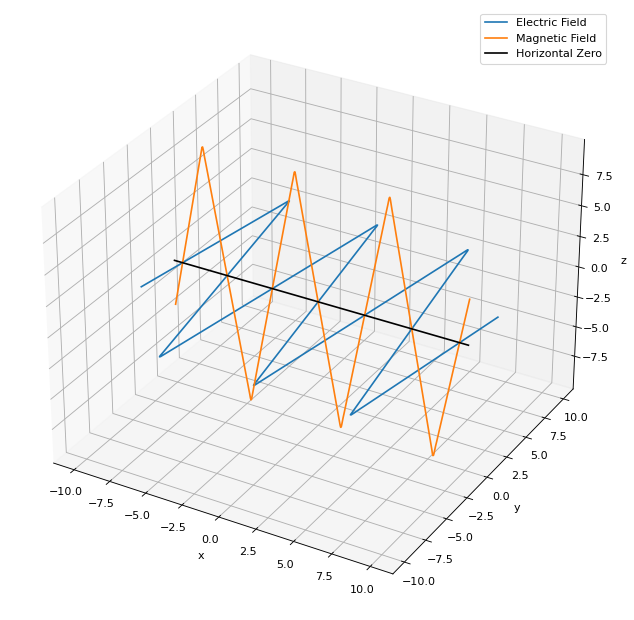

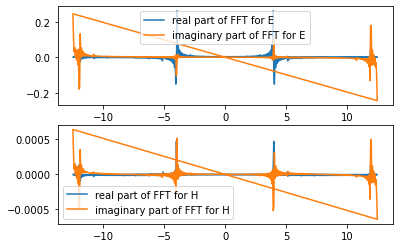

In [8]:
#Reed
def gentriangle(amp,t,num):
    func = 0
    nmax = 2*num-1
    index = np.arange(1,nmax,2)
    L = np.pi
    for n in index:
        func += (((-1)**((n-1)/2))/n**2)*np.sin(n*np.pi*t/L)
    return(amp*(8/(np.pi)**2)*func)

def triangle(amp,freq,t,x,num):
    return(gentriangle(amp,t,num))


def source_triangle(t):
    return triangle(1,omega,t,0,100)

plt.figure(figsize=(10, 10), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(t, -triangle(10,0.2,t,1,20), v,label= 'Electric Field ')
ax.plot3D(t, v, -triangle(10,0.2,t,1,20),label= 'Magnetic Field ')
ax.plot(t,v,v, 'black',label= 'Horizontal Zero',)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

Ex = np.zeros([jmax+1,2])  
Hz = np.zeros([jmax+1,2])  

for n in range(nmax):
  #Magnetic field boundaries
    Hz[jmax-1,1] = Hz[jmax-2,0]
  #Update Magnetic field
    for j in range(jmax-1):
        Hz[j,1] = Hz[j,0] + dt/(dx*mu0) * (Ex[j+1,1] - Ex[j,1])
        Hz[j,0] = Hz[j,1]
  #Magnetic field source
    Hz[jsource-1,1] -= source_triangle(n)/Z

  #Update Electric Field boundaries
    Ex[0,1] = Ex[1,0]
  #Update electric field
    for j in range(1,jmax):
        Ex[j,1] = Ex[j,0] + dt/(dx*eps0) * (Hz[j,1]-Hz[j-1,1])
        Ex[j,0] = Ex[j,1]

  #Electric field source
    Ex[jsource,1] += source_triangle(n+1)
    Ex[jsource,0] = Ex[jsource,1]

 
  #Compute Fourier Transform
tax = np.linspace(-10.,10.,501)
f = np.linspace(-2.,2.,40001)
fE,freqE = ff(Ex[:,0],tax)
fH,freqH = ff(Hz[:,0],tax)

fig = go.Figure()
fig.add_trace(
   go.Scatter3d(x=t, 
                y=Ex[:,1], 
                z=v,
                name = 'Electric Field',
                mode = 'lines'))
fig.add_trace(
   go.Scatter3d(x=t, 
                y=v, 
                z=Hz[:,1],
                name = 'Magnetic Field',
                mode = 'lines'))

fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

fig, axs = py.subplots(2,1)
axs[0].plot(fE, np.real(freqE),label='real part of FFT for E')
axs[0].plot(fE, np.imag(freqE),label='imaginary part of FFT for E')
axs[0].legend()
axs[1].plot(fH, np.real(freqH),label='real part of FFT for H')
axs[1].plot(fH, np.imag(freqH),label='imaginary part of FFT for H')
axs[1].legend()
fig.show()

The final plots follow the same process only for an electric field represented by a sawtooth wave.

C:\Users\blueb\AppData\Local\Temp\ipykernel_16328\3327062047.py:85: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



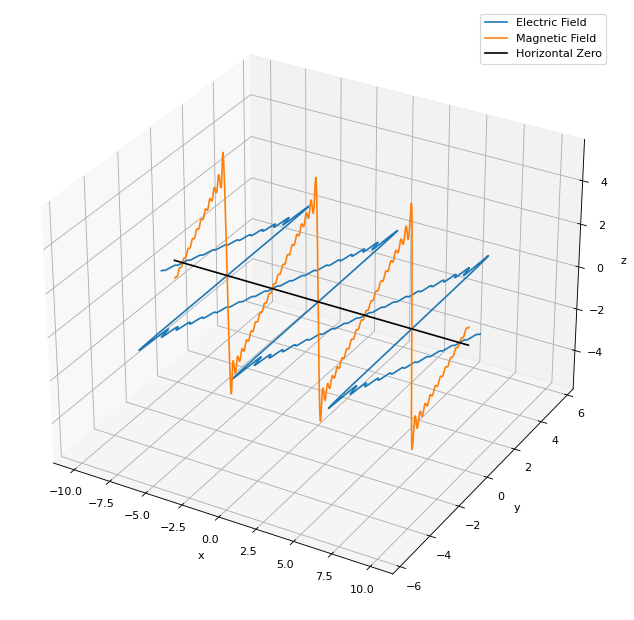

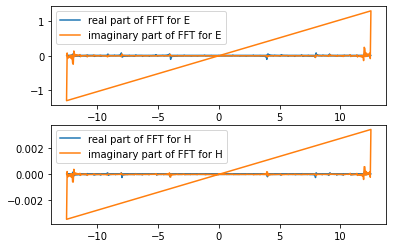

In [9]:
#Reed
def gensawtooth(amp,t,num):
    func = 0
    nmax = num
    index = np.arange(1,nmax,1)
    L = np.pi
    for n in index:
        func += (1/n)*np.sin(n*np.pi*t/L)
    return(amp*(-1/(np.pi))*func)

def sawtooth(amp,freq,t,x,num):
    return(gensawtooth(amp,t,num))

def source_saw(t):
    return sawtooth(1,omega,t,0,100)

plt.figure(figsize=(10, 10), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(t, sawtooth(10,0.2,t,1,20), v,label= 'Electric Field ')
ax.plot3D(t, v, sawtooth(10,0.2,t,1,20),label= 'Magnetic Field ')
ax.plot(t,v,v, 'black',label= 'Horizontal Zero',)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()


Ex = np.zeros([jmax+1,2])  
Hz = np.zeros([jmax+1,2])  

for n in range(nmax):
  #Magnetic field boundaries
    Hz[jmax-1,1] = Hz[jmax-2,0]
  #Update Magnetic field
    for j in range(jmax-1):
        Hz[j,1] = Hz[j,0] + dt/(dx*mu0) * (Ex[j+1,1] - Ex[j,1])
        Hz[j,0] = Hz[j,1]
  #Magnetic field source
    Hz[jsource-1,1] -= source_saw(n)/Z

  #Update Electric Field boundaries
    Ex[0,1] = Ex[1,0]
  #Update electric field
    for j in range(1,jmax):
        Ex[j,1] = Ex[j,0] + dt/(dx*eps0) * (Hz[j,1]-Hz[j-1,1])
        Ex[j,0] = Ex[j,1]

  #Electric field source
    Ex[jsource,1] += source_saw(n+1)
    Ex[jsource,0] = Ex[jsource,1]
    
  #Compute Fourier Transform
tax = np.linspace(-10.,10.,501)
f = np.linspace(-2.,2.,40001)
fE,freqE = ff(Ex[:,0],tax)
fH,freqH = ff(Hz[:,0],tax)

fig = go.Figure()
fig.add_trace(
   go.Scatter3d(x=t, 
                y=Ex[:,1], 
                z=v,
                name = 'Electric Field',
                mode = 'lines'))
fig.add_trace(
   go.Scatter3d(x=t, 
                y=v, 
                z=Hz[:,1],
                name = 'Magnetic Field',
                mode = 'lines'))

fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

fig, axs = py.subplots(2,1)
axs[0].plot(fE, np.real(freqE),label='real part of FFT for E')
axs[0].plot(fE, np.imag(freqE),label='imaginary part of FFT for E')
axs[0].legend()
axs[1].plot(fH, np.real(freqH),label='real part of FFT for H')
axs[1].plot(fH, np.imag(freqH),label='imaginary part of FFT for H')
axs[1].legend()
fig.show()